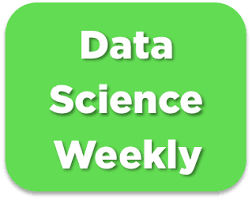

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


# Read file with labels

In [6]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [17]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [7]:
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'

In [8]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [9]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [10]:
numeric_features = ['age', 'total_pages_visited'] # Names of numeric columns in X_train/X_test

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # standardization
])

In [11]:
categorical_features = ['country', 'new_user', 'source'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [12]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5, :])
print()
X_test = preprocessor.transform(X_test)

Performing preprocessings on train set...
...Done.
[[-1.3990984  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.29299544  0.03743241  0.          0.          1.          1.
   1.          0.        ]
 [ 2.46854467 -0.86015697  0.          0.          1.          1.
   0.          0.        ]
 [-1.64082609 -1.15935344  0.          0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.03743241  0.          0.          0.          1.
   0.          1.        ]]



In [14]:
# import pandas for data wrangling
import pandas as pd


# import numpy for Scientific computations
import numpy as np


# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [15]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [20]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [( X_train, Y_train), ( X_test, Y_test)]

    clf.fit(X_train, Y_train,
            eval_set=evaluation, eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(X_test)
    f1 = f1_score(Y_test, pred>0.5)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [21]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                 
0.7448609431680774                                     
  1%|          | 1/100 [00:01<01:50,  1.12s/trial, best loss: -0.7448609431680774]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7453115547489414                                                                
  2%|▏         | 2/100 [00:02<01:45,  1.08s/trial, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7388651616839536                                                                
  3%|▎         | 3/100 [00:02<01:25,  1.14trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7390243902439024                                                                
  4%|▍         | 4/100 [00:03<01:15,  1.28trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7439061089377069                                                                
  5%|▌         | 5/100 [00:04<01:19,  1.19trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7376146788990825                                                                
  6%|▌         | 6/100 [00:05<01:12,  1.30trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7441016333938293                                                                
  7%|▋         | 7/100 [00:06<01:25,  1.09trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7448609431680774                                                                
  8%|▊         | 8/100 [00:07<01:27,  1.05trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7436670687575392                                                                
  9%|▉         | 9/100 [00:08<01:28,  1.03trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                            
0.7450151057401811                                                                
 10%|█         | 10/100 [00:09<01:30,  1.01s/trial, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7241930329178652                                                                 
 11%|█         | 11/100 [00:10<01:24,  1.06trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7446358416440012                                                                 
 12%|█▏        | 12/100 [00:11<01:29,  1.02s/trial, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7410824108241083                                                                 
 13%|█▎        | 13/100 [00:12<01:21,  1.07trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7446358416440012                                                                 
 14%|█▍        | 14/100 [00:13<01:24,  1.02trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7356746765249537                                                                 
 15%|█▌        | 15/100 [00:13<01:15,  1.12trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7448609431680774                                                                 
 16%|█▌        | 16/100 [00:14<01:20,  1.04trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7447065940713853                                                                 
 17%|█▋        | 17/100 [00:16<01:21,  1.02trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7356746765249537                                                                 
 18%|█▊        | 18/100 [00:16<01:11,  1.14trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7400611620795108                                                                 
 19%|█▉        | 19/100 [00:17<01:05,  1.24trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7418270699663917                                                                 
 20%|██        | 20/100 [00:17<01:00,  1.32trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7420537897310514                                                                 
 21%|██        | 21/100 [00:18<00:57,  1.38trial/s, best loss: -0.7453115547489414]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7457729468599034                                                                 
 22%|██▏       | 22/100 [00:19<01:08,  1.14trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7441300421432872                                                                 
 23%|██▎       | 23/100 [00:20<01:10,  1.10trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7420537897310514                                                                 
 24%|██▍       | 24/100 [00:21<01:03,  1.20trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7389312977099236                                                                 
 25%|██▌       | 25/100 [00:22<00:57,  1.30trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7437308868501529                                                                 
 26%|██▌       | 26/100 [00:22<00:54,  1.36trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7397678680513133                                                                 
 27%|██▋       | 27/100 [00:23<00:51,  1.42trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7441016333938293                                                                 
 28%|██▊       | 28/100 [00:24<00:55,  1.29trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7441719648804117                                                                 
 29%|██▉       | 29/100 [00:25<00:59,  1.19trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7439583970633222                                                                 
 30%|███       | 30/100 [00:25<00:55,  1.27trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7445652173913043                                                                 
 31%|███       | 31/100 [00:26<00:58,  1.19trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7455478418351947                                                                 
 32%|███▏      | 32/100 [00:28<01:05,  1.05trial/s, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7457013574660634                                                                 
 33%|███▎      | 33/100 [00:29<01:10,  1.05s/trial, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444814030843666                                                                 
 34%|███▍      | 34/100 [00:30<01:08,  1.03s/trial, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7434110875492276                                                                 
 35%|███▌      | 35/100 [00:31<01:05,  1.00s/trial, best loss: -0.7457729468599034]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7458446660622544                                                                 
 36%|███▌      | 36/100 [00:32<01:09,  1.08s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 37%|███▋      | 37/100 [00:33<01:06,  1.05s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.744790093627303                                                                  
 38%|███▊      | 38/100 [00:34<01:04,  1.04s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7384146341463413                                                                 
 39%|███▉      | 39/100 [00:35<00:56,  1.09trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7441300421432872                                                                 
 40%|████      | 40/100 [00:36<00:56,  1.07trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7450861808285455                                                                 
 41%|████      | 41/100 [00:37<00:56,  1.04trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7401960784313725                                                                 
 42%|████▏     | 42/100 [00:37<00:50,  1.16trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.744270205066345                                                                  
 43%|████▎     | 43/100 [00:38<00:51,  1.11trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7427877315517765                                                                 
 44%|████▍     | 44/100 [00:39<00:52,  1.07trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 45%|████▌     | 45/100 [00:40<00:52,  1.04trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7423368740515933                                                                 
 46%|████▌     | 46/100 [00:41<00:52,  1.03trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.744270205066345                                                                  
 47%|████▋     | 47/100 [00:42<00:51,  1.03trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7448609431680774                                                                 
 48%|████▊     | 48/100 [00:43<00:51,  1.00trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7445652173913043                                                                 
 49%|████▉     | 49/100 [00:44<00:51,  1.01s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 50%|█████     | 50/100 [00:45<00:50,  1.01s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7450390859891762                                                                 
 51%|█████     | 51/100 [00:46<00:48,  1.01trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7401960784313725                                                                 
 52%|█████▏    | 52/100 [00:47<00:43,  1.10trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7441149495567105                                                                 
 53%|█████▎    | 53/100 [00:48<00:39,  1.18trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7454655380894801                                                                 
 54%|█████▍    | 54/100 [00:49<00:46,  1.00s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7442839951865222                                                                 
 55%|█████▌    | 55/100 [00:50<00:44,  1.01trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7448609431680774                                                                 
 56%|█████▌    | 56/100 [00:51<00:43,  1.01trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7384146341463413                                                                 
 57%|█████▋    | 57/100 [00:52<00:38,  1.13trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7439613526570049                                                                 
 58%|█████▊    | 58/100 [00:53<00:38,  1.09trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7447065940713853                                                                 
 59%|█████▉    | 59/100 [00:54<00:38,  1.07trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.744507974721637                                                                  
 60%|██████    | 60/100 [00:55<00:37,  1.07trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7446358416440012                                                                 
 61%|██████    | 61/100 [00:56<00:37,  1.05trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7403551745254133                                                                 
 62%|██████▏   | 62/100 [00:56<00:32,  1.16trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.744790093627303                                                                  
 63%|██████▎   | 63/100 [00:57<00:33,  1.10trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7397678680513133                                                                 
 64%|██████▍   | 64/100 [00:58<00:31,  1.13trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 65%|██████▌   | 65/100 [00:59<00:32,  1.08trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7457013574660634                                                                 
 66%|██████▌   | 66/100 [01:01<00:35,  1.04s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7454764776839568                                                                 
 67%|██████▋   | 67/100 [01:02<00:37,  1.13s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.744790093627303                                                                  
 68%|██████▊   | 68/100 [01:03<00:35,  1.11s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7457013574660634                                                                 
 69%|██████▉   | 69/100 [01:04<00:35,  1.14s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7448609431680774                                                                 
 70%|███████   | 70/100 [01:05<00:33,  1.10s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7446358416440012                                                                 
 71%|███████   | 71/100 [01:06<00:31,  1.08s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7448609431680774                                                                 
 72%|███████▏  | 72/100 [01:07<00:29,  1.06s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7456193353474321                                                                 
 73%|███████▎  | 73/100 [01:08<00:30,  1.13s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7448609431680774                                                                 
 74%|███████▍  | 74/100 [01:10<00:28,  1.10s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7435123717561859                                                                 
 75%|███████▌  | 75/100 [01:11<00:26,  1.06s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 76%|███████▌  | 76/100 [01:12<00:25,  1.04s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7454655380894801                                                                 
 77%|███████▋  | 77/100 [01:13<00:25,  1.11s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7441300421432872                                                                 
 78%|███████▊  | 78/100 [01:14<00:23,  1.07s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7445652173913043                                                                 
 79%|███████▉  | 79/100 [01:15<00:22,  1.06s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7410824108241083                                                                 
 80%|████████  | 80/100 [01:15<00:18,  1.06trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7457013574660634                                                                 
 81%|████████  | 81/100 [01:17<00:20,  1.07s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7446487790171843                                                                 
 82%|████████▏ | 82/100 [01:18<00:18,  1.05s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 83%|████████▎ | 83/100 [01:19<00:17,  1.03s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.744790093627303                                                                  
 84%|████████▍ | 84/100 [01:20<00:16,  1.02s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7450861808285455                                                                 
 85%|████████▌ | 85/100 [01:21<00:15,  1.03s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7447065940713853                                                                 
 86%|████████▌ | 86/100 [01:22<00:14,  1.04s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7452402538531279                                                                 
 87%|████████▋ | 87/100 [01:23<00:13,  1.05s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7441149495567105                                                                 
 88%|████████▊ | 88/100 [01:24<00:11,  1.06trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7450861808285455                                                                 
 89%|████████▉ | 89/100 [01:25<00:11,  1.05s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7446358416440012                                                                 
 90%|█████████ | 90/100 [01:26<00:10,  1.04s/trial, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7403551745254133                                                                 
 91%|█████████ | 91/100 [01:27<00:08,  1.08trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7449441593721702                                                                 
 92%|█████████▏| 92/100 [01:28<00:07,  1.06trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7429447852760735                                                                 
 93%|█████████▎| 93/100 [01:28<00:06,  1.16trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7452402538531279                                                                 
 94%|█████████▍| 94/100 [01:29<00:05,  1.10trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 95%|█████████▌| 95/100 [01:30<00:04,  1.07trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.736064059131506                                                                  
 96%|█████████▌| 96/100 [01:31<00:03,  1.18trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444108761329307                                                                 
 97%|█████████▋| 97/100 [01:32<00:02,  1.10trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7444814030843666                                                                 
 98%|█████████▊| 98/100 [01:33<00:01,  1.07trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7448733413751508                                                                 
 99%|█████████▉| 99/100 [01:34<00:00,  1.06trial/s, best loss: -0.7458446660622544]

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                             
0.7412844036697247                                                                 
100%|██████████| 100/100 [01:35<00:00,  1.05trial/s, best loss: -0.7458446660622544]


In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [15]:
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    #'max_depth': [2, 4, 6], # exactly the same role as in scikit-learn
    #'max_depth': [6, 8, 10, 12], # iteration 2
    'max_depth': [6], # iteration 3
    #'min_child_weight': [1, 2, 3], # effect is more or less similar to min_samples_leaf and min_samples_split
    #'min_child_weight': [3, 4, 5, 6], # iteration 2
    'min_child_weight': [6], # iteration 3
    #'n_estimators': [2, 4, 6, 8,] # exactly the same role as in scikit-learn
    # 'n_estimators': [8, 10, 12, 14, 16] # iteration 2
    'n_estimators': [14] # iteration 3
}
print(params)
best_xgboost = GridSearchCV(xgboost, param_grid = params, cv = 5, scoring = "f1") # cv : the number of folds to be used for CV
best_xgboost.fit(X_train, Y_train)
print("...Done.")

print("Best hyperparameters : ", best_xgboost.best_params_)
print("Best f1-score : ", best_xgboost.best_score_)


Grid search...
{'max_depth': [6], 'min_child_weight': [6], 'n_estimators': [14]}
...Done.
Best hyperparameters :  {'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 14}
Best f1-score :  0.767014136701355


In [16]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_xgboost.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [17]:
print("Performing preprocessings on test set...")

print("Encoding categorical features and standardizing numerical features...")
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:]) 
print()


Performing preprocessings on test set...
Encoding categorical features and standardizing numerical features...
...Done.
[[ 0.41385929 -1.15935344  0.          1.          0.          1.
   0.          0.        ]
 [ 0.1721316   0.03743241  0.          1.          0.          0.
   0.          0.        ]
 [ 1.62249775 -1.15935344  0.          0.          1.          1.
   0.          0.        ]
 [ 0.53472314 -1.15935344  0.          0.          1.          1.
   1.          0.        ]
 [-0.19045994 -0.56096051  0.          0.          1.          1.
   1.          0.        ]]



In [18]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_xgboost.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [19]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7708411214953271
f1-score on test set :  0.7489539748953975


In [20]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219444    876]
 [  2189   5155]]

Confusion matrix on test set : 
[[54823   257]
 [  583  1253]]



# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [21]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

best_xgboost.fit(X,Y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [6], 'min_child_weight': [6],
                         'n_estimators': [14]},
             scoring='f1')

In [22]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

Prediction set (without labels) : (31620, 5)


In [23]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31132378  3.3285935   0.          1.          0.          0.
   0.          1.        ]
 [-1.03650686  0.03743241  0.          1.          0.          1.
   1.          0.        ]
 [ 0.1721316  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.1721316   0.33662888  0.          0.          1.          1.
   0.          0.        ]
 [-0.67391532 -0.56096051  0.          0.          0.          0.
   0.          1.        ]]


In [24]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': best_xgboost.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_YULIYA-model4.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**